In [15]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from position import *

In [5]:
grapplemap = pd.read_csv('grapplemap_df.csv',dtype={'trans_start_node': 'string', 'trans_end_node': 'string'})
positions = grapplemap[grapplemap['is_position'] == 1]
transitions = grapplemap[grapplemap['is_transition'] == 1]
#
grapplemap.head()

,description,properties,tags,code,is_position,is_transition,start_position,end_position,trans_start_node,trans_end_node
0,side ctrl w/ near open elbow and crossface,NaN,side_control top_underhook bottom_supine cross...,Q2aAwQJFazuRQGddznKqcxxSRkbTzoJpbsxEToa1FVGgaY...,1,0,NaN,NaN,<NA>,<NA>
1,twister side control,NaN,twister_side top_on_side side_control bottom_s...,DPaUwxULaRrgHtaEvNVYbjuKGFaEwZUHbgt6JaceDeO6d0...,1,0,NaN,NaN,<NA>,<NA>
2,north south,NaN,north_south bottom_supine top_kneeling,5oazN44BazJj26drNp17dnJh2VcaN819b3INWBa3QRVQa5...,1,0,NaN,NaN,<NA>,<NA>
3,seated back w/ hook on underhook side,NaN,back seatbelt top_seated,LKaAKZNKfQIVOBaENkN7dlLCNcaUNvOWexLiIAerReVhfL...,1,0,NaN,NaN,<NA>,<NA>
4,full guard kimura,NaN,full_guard kimura bottom_supine top_kneeling t...,ANaAxzxXaBCzBTaGA5zYbZFiCDaHzPzUaEEKI5bABQEjbs...,1,0,NaN,NaN,<NA>,<NA>


In [17]:
## OG implementation that add positions for any edges that don't have start or end positions as nodes already.

# Create a directed graph
G = nx.DiGraph()    

def find_or_add_node(position,row,G):
    # note: doesn't need row
    #check if node exists
    for node in G.nodes():
        if positions_are_equivalent(position,Position(node)):
            return node
    #makes new node if it doesn't exist
    G.add_node(position.codeblock,description='Unknown', tags='Unknown', is_explicit_position=False, from_transition=row['description'])
    return position.codeblock
    
# Add nodes (positions)
for _, row in positions.iterrows():
    G.add_node(row['code'], description=row['description'], tags=row['tags'], properties=row['properties'],is_explicit_position=True)

# Add edges (transitions)

#change dtype
transitions['trans_start_node'] = transitions['trans_start_node'].astype('string')
transitions['trans_end_node'] = transitions['trans_end_node'].astype('string')

for idx, row in tqdm(transitions.iterrows(), total=len(transitions), desc="Processing transitions"):
    start_pos = Position(row['start_position'])
    end_pos = Position(row['end_position'])
    
    start_node = find_or_add_node(start_pos,row,G)
    transitions.loc[idx,'trans_start_node'] = start_node
    end_node = find_or_add_node(end_pos,row,G)
    transitions.loc[idx,'trans_end_node'] = end_node

    # Add the edge (transition)
    G.add_edge(start_node, end_node, description=row['description'], tags=row['tags'], properties=row['properties'])

    #add edge in opposite direction if the move is bidirectional 
    if type(row['properties']) == str and 'bidirectional' in row['properties']:
            G.add_edge(end_node,start_node, description=row['description'], tags=row['tags'], properties=row['properties'])

            
transitions.to_csv('graph_transitions.csv')
# Basic graph information
print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")

/var/folders/2t/b3q12phj425429z82g8rrbv40000gn/T/ipykernel_15805/3922063839.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  transitions['trans_start_node'] = transitions['trans_start_node'].astype('string')
/var/folders/2t/b3q12phj425429z82g8rrbv40000gn/T/ipykernel_15805/3922063839.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  transitions['trans_end_node'] = transitions['trans_end_node'].astype('string')
Processing transitions: 100%|███████████████████████████████████████████████████████████████

Number of nodes: 872
Number of edges: 1508


In [18]:
# nx.write_gexf(G, "grapplemap_0805.gexf")
# nx.write_graphml_lxml(G, "grapplemap_0805.graphml")

# def save_graph_with_all_attributes(G, filename):
#     # Ensure all attribute values are of supported types
#     for node, data in G.nodes(data=True):
#         for key, value in data.items():
#             if not isinstance(value, (str, float, bool, int)):
#                 G.nodes[node][key] = str(value)

#     for u, v, data in G.edges(data=True):
#         for key, value in data.items():
#             if not isinstance(value, (str, float, bool, int)):
#                 G[u][v][key] = str(value)

#     # Write the graph to a GraphML file
#     nx.write_graphml(G, filename, named_key_ids=True)

#     print(f"Graph saved to {filename} with all attributes.")

# save_graph_with_all_attributes(G, "grapplemap_0805_attributes.graphml")

g_transitions = pd.read_csv('graph_transitions.csv')

G2 = nx.DiGraph()    

# Add nodes (positions)
for _, row in positions.iterrows():
    G2.add_node(row['code'], description=row['description'], tags=row['tags'], properties=row['properties'],is_explicit_position=True)

for _, row in g_transitions.iterrows():
    # Add the edge (transition)
    G2.add_edge(row['trans_start_node'], row['trans_end_node'], description=row['description'], tags=row['tags'], properties=row['properties'])

    #add edge in opposite direction if the move is bidirectional 
    if type(row['properties']) == str and 'bidirectional' in row['properties']:
            G2.add_edge(row['trans_end_node'],row['trans_start_node'], description=row['description'], tags=row['tags'], properties=row['properties'])

In [19]:
def graphs_are_identical(G1, G2):
    # Check if they have the same nodes
    if set(G1.nodes()) != set(G2.nodes()):
        print('diff nodes')
        return False
    
    # Check if they have the same edges
    if set(G1.edges()) != set(G2.edges()):
        print('diff edges')
        return False
    
    # Check node attributes
    for node in G1.nodes():
        if G1.nodes[node] != G2.nodes[node]:
            print('diff node attributes')
            return False
    
    # Check edge attributes
    for edge in G1.edges():
        if G1.edges[edge] != G2.edges[edge]:
            print('diff edge attributes')
            return False
    
    return True

# Usage
# G2 = nx.read_graphml("grapplemap_0805_attributes.graphml")
are_identical = graphs_are_identical(G, G2)

if are_identical:
    print("The graphs are exactly the same")
else:
    print("The graphs are different")

diff node attributes
The graphs are different


In [20]:
transitions_copy.to_csv('matched_transitions.csv')

NameError: name 'transitions_copy' is not defined

In [21]:
# Assuming 'G' is your NetworkX DiGraph

# Find terminal nodes (nodes with out-degree of 0)
terminal_nodes = [node for node, out_degree in G.out_degree() if out_degree == 0]

# Print the list of terminal nodes
print("Terminal nodes:")

for node in terminal_nodes:
    if G.nodes[node].get('is_explicit_position') == True:
        print(G.nodes[node].get('description'))
#     print(type(node))
#     print(node['description'])

# Print the count of terminal nodes
print(f"\nTotal number of terminal nodes: {len(terminal_nodes)}")

# If you want to get more information about these terminal positions
terminal_positions_info = []
for node in terminal_nodes:
    node_data = G.nodes[node]
    terminal_positions_info.append({
        'node': node,
        'description': node_data.get('description', 'No description available'),
        'tags': node_data.get('tags', []),
        'is_explicit_position': node_data.get('is_explicit_position', False)
    })

# # Print detailed information about terminal positions
# print("\nDetailed information about terminal positions:")
# for info in terminal_positions_info:
#     print(f"Node: {info['node']}")
#     print(f"Description: {info['description']}")
#     print(f"Tags: {', '.join(info['tags'])}")
#     print(f"Is Explicit Position: {info['is_explicit_position']}")
#     print()

Terminal nodes:
mono w/ figure four and foot-in-armpit
side control w/ near arm pin and far underhook
octopus half guard
bottom throwing leg up
standing single-leg turned away
gator roll
japanese necktie w/ top leg trapped
electric chair submission
kung fu move w/ leg trapped
mounted triangle
mount w/ double unders
lister v. barnett
standing vs darce
cocoon w/ overhook
over/under cocoon w/ head on overhook side
japanese necktie
kneeling darce vs half guard w/ underhook
distance closed guard
postured up omoplata
completed o-soto-gari
butterflies engaged w/ over/under body lock
double knee bar
6 o'clock homie
arm crush
3/4 mount w/ underhook
top lock clinch
tony montana
game over
knee knot
turtle crucified w/ one leg
turned in t-rex vs side vice
double leg vs reverse leg
butterfly ashi
rat guard
entering side control w/ kimura
half guard kimura
rev. mounted triangle-crucifix- kimura
arm-in guillotine vs single leg
new jersey w/ overhook
north/south vs elbow frame
top 3/4 lockdown
caught 

In [153]:
def split_69(string):
    return [string[i:i+69] for i in range(0, len(string), 69)]

In [298]:
unrelated_position = transitions.iloc[0]['start_position']

In [22]:
import string
import numpy as np

BASE62_DIGITS = string.digits + string.ascii_lowercase + string.ascii_uppercase

def decode_position(encoded_string: str) -> Position:
    def base62_to_int(s):
        return BASE62_DIGITS.index(s[0]) * 62 + BASE62_DIGITS.index(s[1])

    def next_coord():
        nonlocal offset
        if offset + 2 > len(encoded_string):
            raise ValueError(f"Reached end of string at offset {offset}")
        value = base62_to_int(encoded_string[offset:offset+2]) / 1000
        offset += 2
        return value

    offset = 0
    position = {}
    
    try:
        for player in range(2):
            for joint in range(23):  # Assuming 23 joints per player
                x = next_coord() - 2
                y = next_coord()
                z = next_coord() - 2
                position[(player, joint)] = np.array([x, y, z])
    except ValueError as e:
        print(f"Decoding stopped at joint {player * 23 + joint}, coordinate {'xyz'[len(position) % 3]}")
        print(f"Error: {str(e)}")
        print(f"Decoded {len(position)} joints completely")
    
    return position

# Example usage:
encoded_pos = transitions[transitions['description'] == 'to honey']['start_position'].iloc[1]

decoded_pos = decode_position(encoded_pos)
print(f"Decoded {len(decoded_pos)} joints")

Decoded 46 joints


In [23]:
from enum import Enum
#defining joint class and mirror logic
class Joint(Enum):
    LeftToe = 0
    RightToe = 1
    LeftHeel = 2
    RightHeel = 3
    LeftAnkle = 4
    RightAnkle = 5
    LeftKnee = 6
    RightKnee = 7
    LeftHip = 8
    RightHip = 9
    LeftShoulder = 10
    RightShoulder = 11
    LeftElbow = 12
    RightElbow = 13
    LeftWrist = 14
    RightWrist = 15
    LeftHand = 16
    RightHand = 17
    LeftFingers = 18
    RightFingers = 19
    Core = 20
    Neck = 21
    Head = 22

# Create a mapping of joint names to their mirror counterparts
MIRROR_JOINTS = {
    Joint.LeftToe: Joint.RightToe,
    Joint.LeftHeel: Joint.RightHeel,
    Joint.LeftAnkle: Joint.RightAnkle,
    Joint.LeftKnee: Joint.RightKnee,
    Joint.LeftHip: Joint.RightHip,
    Joint.LeftShoulder: Joint.RightShoulder,
    Joint.LeftElbow: Joint.RightElbow,
    Joint.LeftWrist: Joint.RightWrist,
    Joint.LeftHand: Joint.RightHand,
    Joint.LeftFingers: Joint.RightFingers,
}
# Add reverse mappings
MIRROR_JOINTS.update({v: k for k, v in MIRROR_JOINTS.items()})

def mirror_joint(joint: int) -> int:
    joint_enum = Joint(joint)
    if joint_enum in MIRROR_JOINTS:
        return MIRROR_JOINTS[joint_enum].value
    return joint

In [461]:
import numpy as np
from scipy.spatial.transform import Rotation

class Position:
    def __init__(self, input):
        if type(input) == str:
            self.code = input
            self.coords_dict = decode_position(input)
        elif type(input) == dict:
            self.coords_dict = input
            

    def __getitem__(self, key):
        return self.coords_dict[key]

    def items(self):
        return self.coords_dict.items()

def mirror_position(pos):
    mirrored = Position({k: np.array([-v[0], v[1], v[2]]) for k, v in pos.items()})
    return mirrored

def swap_players(pos):
    swapped = Position({(1-k[0], k[1]): v for k, v in pos.items()})
    return swapped

def center(pos):
    return (pos[(0, 0)] + pos[(1, 0)]) / 2  # Assuming joint 0 is the core

def heading(pos):
    return pos[(1, 0)] - pos[(0, 0)]  # Vector from player 0 core to player 1 core

def normal_rotation(pos):
    h = heading(pos)
    return np.arctan2(h[2], h[0])

def translate(pos, offset):
    translated = Position({k: v + offset for k, v in pos.items()})
    return translated

def rotate(pos, angle):
    r = Rotation.from_rotvec([0, angle, 0])
    rotated = Position({k: r.apply(v) for k, v in pos.items()})
    return rotated

def orient_canonically(pos, should_mirror=False):
    if should_mirror:
        pos = mirror_position(pos)
    
    # Center the position
    c = center(pos)
    pos = translate(pos, -c)
    
    # Rotate to align with x-axis
    angle = normal_rotation(pos)
    pos = rotate(pos, -angle)
    
    return pos

def basically_same(pos1, pos2, tolerance=0.2):
    return all(np.sum((pos1[k] - pos2[k])**2) < tolerance for k in pos1.coords_dict.keys())

def positions_are_equivalent(pos1, pos2):
    
    # Try without mirroring
    oriented1 = orient_canonically(pos1)
    oriented2 = orient_canonically(pos2)
    
    if basically_same(oriented1, oriented2):
        return True
    
    # Try with mirroring
    oriented1_mirrored = orient_canonically(pos1, should_mirror=True)
    
    if basically_same(oriented1_mirrored, oriented2):
        return True
    
    # Try with player swapping
    oriented1_swapped = orient_canonically(swap_players(pos1))
    
    if basically_same(oriented1_swapped, oriented2):
        return True
    
    # Try with both mirroring and player swapping
    oriented1_mirrored_swapped = orient_canonically(swap_players(pos1), should_mirror=True)
    
    if basically_same(oriented1_mirrored_swapped, oriented2):
        return True
    
    return False

# Example usage:

pos1 = Position(imanari)
pos2 = Position(honey)

#pos2 = Position(decode_position(unrelated_position))

result = positions_are_equivalent(pos1, pos2)
print(f"Positions are equivalent: {result}")

Positions are equivalent: False


In [464]:
transitions[transitions['trans_start_node'] == honey]#.iloc[0]

,description,properties,tags,code,is_position,is_transition,start_position,end_position,trans_start_node,trans_end_node
1616,far knee finish,NaN,NaN,['Kjbf9jYHaX2kJ7eF7XU5aM2TJUdm7mVWbJ2jIWaY0WUl...,0,1,Kjbf9jYHaX2kJ7eF7XU5aM2TJUdm7mVWbJ2jIWaY0WUlhJ...,zUaRC0EhazN7BkeaCjBgaELVBUcRCeCqbqL7HKaYy7IdcR...,Kjbf9jYHaX2kJ7eF7XU5aM2TJUdm7mVWbJ2jIWaY0WUlhJ...,zUaRC0EhazN7BkeaCjBgaELVBUcRCeCqbqL7HKaYy7IdcR...


In [487]:
imanari = positions[positions['description'] == 'sweep single']['code'].iloc[0]
honey = transitions[transitions['description'] == 'far knee finish']['trans_start_node'].iloc[0]

positions_are_equivalent(Position(decode_position(imanari)),Position(decode_position(honey)))

False

In [24]:
# # Step 1: Decode the strings into positions
imanari = positions[positions['description'] == 'completed imanari roll']['code'].iloc[0]
honey = transitions[transitions['description'] == 'to honey']['start_position'].iloc[1]

# imanari = positions[positions['description'] == 'flanking after standing drag']['code'].iloc[0]
# honey = transitions[transitions['description'] == 'crotch rocket']['start_position'].iloc[0]


# pos1 = decode_position(imanari)
# pos2 = decode_position(honey)

# def positions_equivalent(pos1,pos2):
#     # Step 1: Decode the strings into positions
#     pos1 = decode_position(pos1)
#     pos2 = decode_position(pos2)
#     # Step 2: Orient the positions canonically (this makes them relative)
#     relative_pos1 = orient_canonically_with_mirror(pos1)
#     relative_pos2 = orient_canonically_with_mirror(pos2)
    
#     # Step 3: Check if the positions are equivalent
#     if positions_are_equivalent(relative_pos1, relative_pos2):
#         print("The positions are equivalent")
#     else:
#         print("The positions are different")
    
#     # Alternatively, you can use is_reoriented for more detailed information
#     reorientation = is_reoriented(relative_pos1, relative_pos2)
#     if reorientation is not None:
#         print("The positions are equivalent with the following reorientation:")
#         print(f"Angle: {reorientation.reorientation.angle}")
#         print(f"Offset: {reorientation.reorientation.offset}")
#         print(f"Mirrored: {reorientation.mirror}")
#         print(f"Players swapped: {reorientation.swap_players}")
#     else:
#         print("The positions are different")

In [25]:
imanari = positions[positions['description'] == 'twister side control']['code'].iloc[0]#
honey = transitions[transitions['description'] == 'to north/south']['start_position'].iloc[0]



positions_are_equivalent(Position(decode_position(imanari)),Position(decode_position(honey)))

False

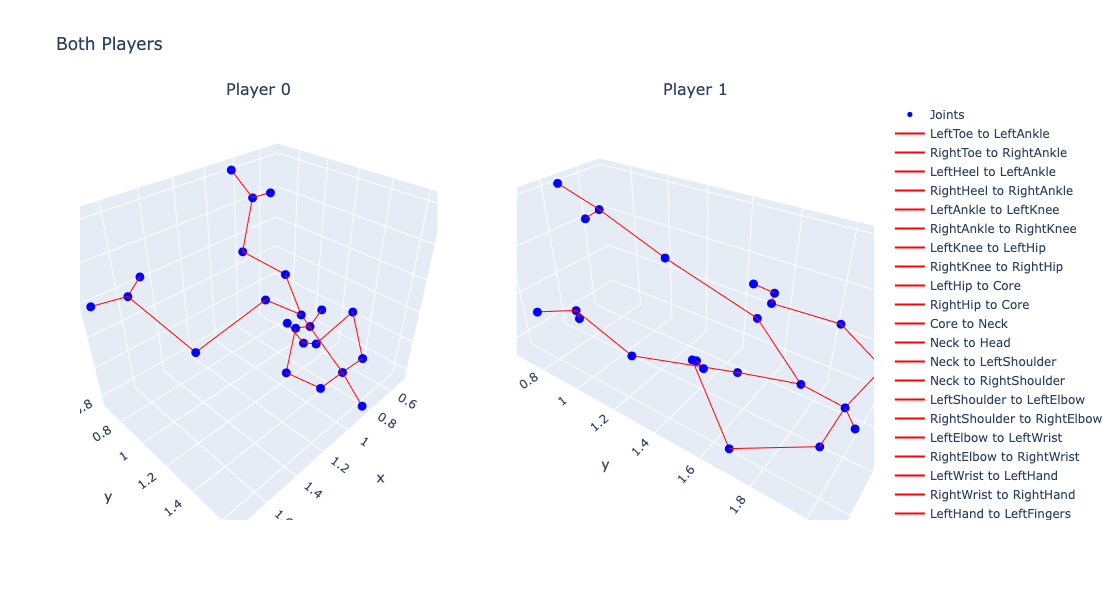

In [494]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import numpy as np

# Assuming we still have the Joint enum and SKELETON_CONNECTIONS defined as before

def plot_player_skeleton_plotly(position, player=0):
    """
    Create a Plotly figure of a player's skeleton using the decoded coordinates.
    
    :param position: A dictionary of joint positions, as returned by decode_position
    :param player: The player to plot (0 or 1)
    :return: A Plotly Figure object
    """
    # Extract x, y, z coordinates for all joints of the player
    x = [position[(player, joint.value)][0] for joint in Joint]
    y = [position[(player, joint.value)][1] for joint in Joint]
    z = [position[(player, joint.value)][2] for joint in Joint]
    
    # Create scatter plot for joints
    joints_trace = go.Scatter3d(
        x=x, y=y, z=z,
        mode='markers',
        marker=dict(size=5, color='blue'),
        name='Joints'
    )
    
    # Create line segments for skeleton connections
    lines_traces = []
    for start, end in SKELETON_CONNECTIONS:
        start_point = position[(player, start.value)]
        end_point = position[(player, end.value)]
        trace = go.Scatter3d(
            x=[start_point[0], end_point[0]],
            y=[start_point[1], end_point[1]],
            z=[start_point[2], end_point[2]],
            mode='lines',
            line=dict(color='red', width=2),
            name=f'{start.name} to {end.name}'
        )
        lines_traces.append(trace)
    
    # Combine all traces
    traces = [joints_trace] + lines_traces
    
    # Create the layout
    layout = go.Layout(
        scene=dict(
            xaxis_title='X',
            yaxis_title='Y',
            zaxis_title='Z',
            aspectmode='data'  # This ensures equal aspect ratio
        ),
        title=f'Player {player} Skeleton'
    )
    
    # Create and return the figure
    fig = go.Figure(data=traces, layout=layout)
    return fig

def plot_both_players_plotly(position):
    """
    Create a Plotly figure with skeletons for both players side by side.
    
    :param position: A dictionary of joint positions, as returned by decode_position
    :return: A Plotly Figure object
    """
    # Create subplots
    fig = make_subplots(
        rows=1, cols=2,
        specs=[[{'type': 'scene'}, {'type': 'scene'}]],
        subplot_titles=('Player 0', 'Player 1')
    )
    
    # Plot player 0
    player0_fig = plot_player_skeleton_plotly(position, player=0)
    for trace in player0_fig.data:
        fig.add_trace(trace, row=1, col=1)
    
    # Plot player 1
    player1_fig = plot_player_skeleton_plotly(position, player=1)
    for trace in player1_fig.data:
        fig.add_trace(trace, row=1, col=2)
    
    # Update layout
    fig.update_layout(height=600, width=1200, title_text="Both Players")
    
    return fig




# Example usage:
encoded_position = imanari
decoded_position = decode_position(encoded_position)
fig = plot_both_players_plotly(decoded_position)
fig.show()

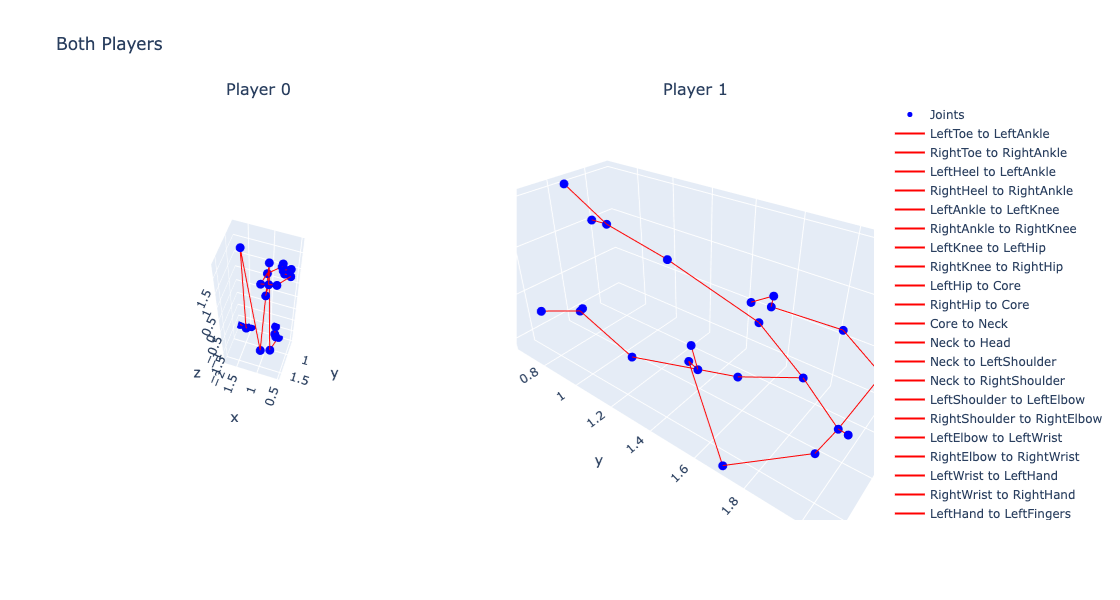

In [495]:
fig = plot_both_players_plotly((decode_position(honey)))
fig.show()

In [489]:
# import numpy as np
# from scipy.spatial.transform import Rotation

# class Position:
#     def __init__(self, coords_dict):
#         self.coords_dict = coords_dict

#     def __getitem__(self, key):
#         return self.coords_dict[key]

#     def items(self):
#         return self.coords_dict.items()

# def mirror_position(pos):
#     mirrored = Position({k: np.array([-v[0], v[1], v[2]]) for k, v in pos.items()})
#     return mirrored

# def swap_players(pos):
#     swapped = Position({(1-k[0], k[1]): v for k, v in pos.items()})
#     return swapped

# def center(pos):
#     return (pos[(0, 0)] + pos[(1, 0)]) / 2  # Assuming joint 0 is the core

# def heading(pos):
#     return pos[(1, 0)] - pos[(0, 0)]  # Vector from player 0 core to player 1 core

# def normal_rotation(pos):
#     h = heading(pos)
#     return np.arctan2(h[2], h[0])

# def translate(pos, offset):
#     translated = Position({k: v + offset for k, v in pos.items()})
#     return translated

# def rotate(pos, angle):
#     r = Rotation.from_rotvec([0, angle, 0])
#     rotated = Position({k: r.apply(v) for k, v in pos.items()})
#     return rotated

# def orient_canonically(pos, should_mirror=False):
#     if should_mirror:
#         pos = mirror_position(pos)
    
#     # Center the position
#     c = center(pos)
#     pos = translate(pos, -c)
    
#     # Rotate to align with x-axis
#     angle = normal_rotation(pos)
#     pos = rotate(pos, -angle)
    
#     return pos

# def basically_same(pos1, pos2, tolerance=0.04):
#     return all(np.sum((pos1[k] - pos2[k])**2) < tolerance for k in pos1.coords_dict.keys())

# def positions_are_equivalent(pos1, pos2):
#     # Try without mirroring
#     oriented1 = orient_canonically(pos1)
#     oriented2 = orient_canonically(pos2)
    
#     if basically_same(oriented1, oriented2):
#         return True
    
#     # Try with mirroring
#     oriented1_mirrored = orient_canonically(pos1, should_mirror=True)
    
#     if basically_same(oriented1_mirrored, oriented2):
#         return True
    
#     # Try with player swapping
#     oriented1_swapped = orient_canonically(swap_players(pos1))
    
#     if basically_same(oriented1_swapped, oriented2):
#         return True
    
#     # Try with both mirroring and player swapping
#     oriented1_mirrored_swapped = orient_canonically(swap_players(pos1), should_mirror=True)
    
#     if basically_same(oriented1_mirrored_swapped, oriented2):
#         return True
    
#     return False

# # Example usage:
# pos1 = Position(decode_position(imanari))
# pos2 = Position(decode_position(honey))

# result = positions_are_equivalent(pos1, pos2)
# print(f"Positions are equivalent: {result}")

In [498]:
positions[positions['description'] == 'back step pass']#['code'].iloc[0]

,description,properties,tags,code,is_position,is_transition,start_position,end_position,trans_start_node,trans_end_node
130,back step pass,NaN,pass half_guard twister_side bottom_turned_in ...,q7aEHECHdUydsXaEKUCCaIz9tda0JzCAb6AvxUe2GxBZga...,1,0,NaN,NaN,NaN,NaN


In [499]:
transitions[transitions['description'] == 'top tries to free leg']

,description,properties,tags,code,is_position,is_transition,start_position,end_position,trans_start_node,trans_end_node
951,top tries to free leg,top,NaN,['AzaEUCxrdUF0EjaEUsy7aIGXDfa0TCzrb6G9CFe2N3D8...,0,1,AzaEUCxrdUF0EjaEUsy7aIGXDfa0TCzrb6G9CFe2N3D8ga...,AWc3JYwIdOE7DvaELgyvaEF3CSbOLJyHb2GcEIh7NPEzd4...,AzaEUCxrdUF0EjaEUsy7aIGXDfa0TCzrb6G9CFe2N3D8ga...,AWc3KiwIdOFrDvaELAyvaEGnCSbOL3yHb2GwEIh7N9Ezd4...
